# №10 Зависимость между поставщиком и категорией прибыльности

**Формулировка гипотезы**   
  
H₀: Категория прибыльности не зависит от поставщика.  
H₁: Категория прибыльности зависит от поставщика.  

**Тесты**
- Monte-Carlo χ² (перестановочный)
    - Пост-хок парные permutation-тесты (Holm, Benjamini–Hochberg)

In [1]:
# Установка переменной среды
import os
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.cluster import KMeans

### Загрузка данных

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
from scipy.stats import skew, kurtosis, probplot
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [3]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [4]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [5]:
cleaned_data['profit_without_discount'] = (cleaned_data['dr_croz'] - cleaned_data['dr_czak']) * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_tabempl', 'dr_apt', 'dr_nchk', 'dr_dat']).agg({'profit_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_suppl':'max'}).reset_index()
grouped['profit'] = grouped['profit_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_tabempl,dr_apt,dr_nchk,dr_dat,profit_without_discount,dr_sdisc,dr_suppl,profit
0,15,11,2491,2022-05-03,349.08,0.0,Протек,349.08
1,15,11,2497,2022-05-04,93.31,0.0,Катрен г.Химки,93.31
2,15,11,2499,2022-05-04,110.30,0.0,Катрен г.Химки,110.30
3,15,11,2501,2022-05-04,48.90,0.0,Протек,48.90
4,15,11,2503,2022-05-04,36.23,0.0,Катрен г.Химки,36.23


### EDA

**Визуализация распределений**

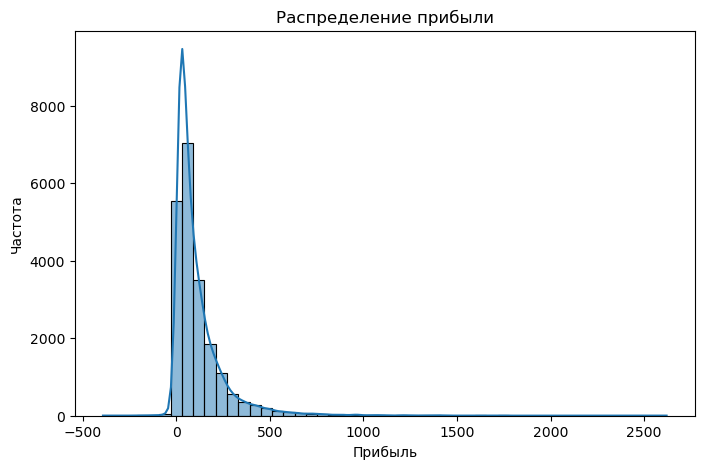

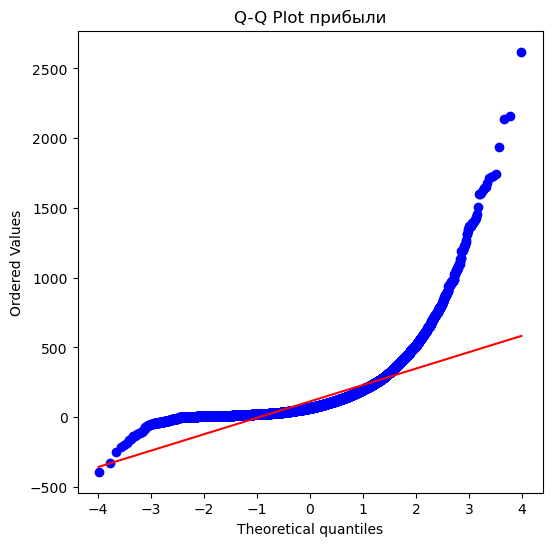

In [6]:
# 1. --гистограмма + KDE
plt.figure(figsize=(8, 5))
sns.histplot(grouped['profit'], bins=50, kde=True)
plt.title("Распределение прибыли")
plt.xlabel("Прибыль")
plt.ylabel("Частота")
plt.show()

# 2. --Q-Q plot
plt.figure(figsize=(6, 6))
probplot(grouped['profit'], dist="norm", plot=plt)
plt.title("Q-Q Plot прибыли")
plt.show()

Распределение прибыли имеет ярко выраженную правостороннюю (положительную) асимметрию, с основной массой наблюдений, сосредоточенной вблизи нуля, и длинным "хвостом" в сторону положительных значений. Это свидетельствует о том, что в выборке преобладают малые прибыли, тогда как высокие прибыли встречаются реже, но могут существенно превышать средний уровень. Распределение несимметрично и, вероятно, не является нормальным.

Q-Q график прибыли демонстрирует существенное отклонение от нормального распределения. Наблюдается явное отклонение точек от прямой линии, особенно в правом "хвосте" распределения, что свидетельствует о наличии положительной асимметрии и тяжёлого хвоста. Это подтверждает, что распределение прибыли не является нормальным и характеризуется присутствием выбросов и экстремальных значений.

In [7]:
# расчёт коэффициентов
skewness = skew(grouped['profit'])
kurt = kurtosis(grouped['profit'])
print(f"Skewness (асимметрия): {skewness:.3f}")
print(f"Kurtosis (эксцесс): {kurt:.3f}")

Skewness (асимметрия): 4.024
Kurtosis (эксцесс): 28.667


Показатели асимметрии (4.024) и эксцесса (28.667) существенно отклоняются от значений, характерных для нормального распределения (асимметрия ≈ 0, эксцесс ≈ 3). Это свидетельствует о сильной правосторонней асимметрии и островершинности распределения с тяжёлыми хвостами, что указывает на наличие значительного числа экстремальных положительных значений (выбросов) и резкое отклонение от нормальности.
- Сильно скошено вправо (Skewness = 4.0).
- Острое (Kurtosis = 28.7, тяжелые хвосты, сильные выбросы).   
Это значит, что пороговое разбиение по среднему/стандартному отклонению не подойдет, т.к. оно будет искажено редкими очень большими значениями.

В данной ситуации для категориального анализа выбрано квантильное разбиение.    
Квартильное разбиение (qcut) на 3 группы:   
- низкая прибыльность (0–33%)
- средняя прибыльность (33–66%)
- высокая прибыльность (66–100%)

**Формирование выборок**

In [8]:
# 3 группы (низкая/средняя/высокая):
grouped['profit_category_3'] = pd.qcut(grouped['profit'], 
                                       q=3, 
                                       labels=['низкая', 'средняя', 'высокая'])

**Статистика по группам**

In [9]:
# 1. Статистика 
grouped.groupby('profit_category_3', observed=True)['profit'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,profit_category_3,mean,median,count
0,низкая,19.18,20.47,6994
1,средняя,68.31,65.74,6996
2,высокая,249.49,190.15,6992


**Распределение прибыли с квартилями**

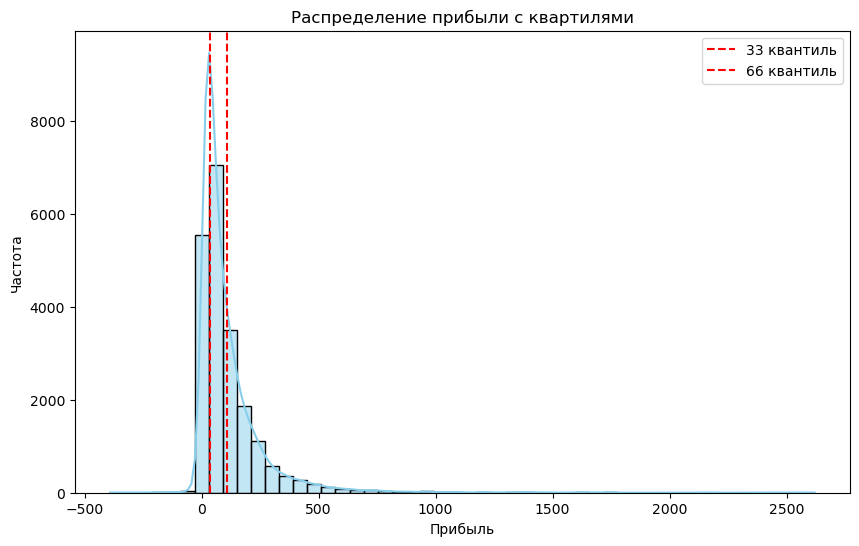

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(grouped['profit'], bins=50, kde=True, color='skyblue')

# Добавим вертикальные линии по квартилям
for q in [0.33, 0.66]:
    plt.axvline(grouped['profit'].quantile(q), color='red', linestyle='--', label=f'{q*100:.0f} квантиль')

plt.title("Распределение прибыли с квартилями")
plt.xlabel("Прибыль")
plt.ylabel("Частота")
plt.legend()
plt.show()

### Таблица сопряжённости

Таблица сопряжённости показывает, сколько продаж каждого уровня прибыльности относится к каждому поставщику.

In [11]:
# Разбиение прибыли на 3 категории по квантилям
grouped['profit_category_3'] = pd.qcut(
    grouped['profit'], 
    q=3, 
    labels=['низкая', 'средняя', 'высокая']
)

# Таблица сопряженности: сколько продаж в каждой категории у каждого поставщика
contingency_table = pd.crosstab(
    grouped['dr_suppl'],       # строки: поставщики
    grouped['profit_category_3']  # столбцы: категории прибыли
)

# Добавим общие итоги по строкам и столбцам для удобства
contingency_table = contingency_table.assign(Всего=contingency_table.sum(axis=1))
contingency_table.loc['Итого'] = contingency_table.sum()

# Выведем результат
contingency_table

profit_category_3,низкая,средняя,высокая,Всего
dr_suppl,,,,
АЛВИЛС ООО,0,0,1,1
Авеста,183,169,62,414
Арал плюс,134,100,74,308
БСС,69,37,20,126
ВИТТА КОМПАНИ ООО,154,103,93,350
Вернигор Николай Викторович,0,1,0,1
ГК Надежда Фарм,126,66,32,224
ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,562,413,242,1217
ЕАПТЕКА ООО,137,164,65,366


Для обеспечения корректности статистического анализа поставщики с числом наблюдений менее 30 были объединены в одну категорию под названием "Другие", поскольку статистические методы требуют достаточного объёма данных в каждой группе.  

In [12]:
# === Объединяем мелких поставщиков ===
# Порог по числу продаж — 30 
threshold = 30

supplier_counts = grouped['dr_suppl'].value_counts()
rare_suppliers = supplier_counts[supplier_counts < threshold].index

# Объединяем мелких поставщиков
grouped['supplier_grouped'] = grouped['dr_suppl'].replace(rare_suppliers, 'Другие')

# === Таблица сопряженности ===
contingency_table = pd.crosstab(
    grouped['supplier_grouped'],
    grouped['profit_category_3']
)

## Monte-Carlo χ² (перестановочный)

### Проверка предпосылок

- Все наблюдения независимы (одно наблюдение = одна продажа). Выполняется, т.к. каждая строка — отдельный чек.
- Переменные категориальные:
    - поставщик (supplier_grouped)
    - прибыльность (profit_category_3)
- Нет пропусков (NaN)

### Проведение теста

In [13]:
# --------------------------------------------
# 1. === Классический χ² (для сравнения) ===
# --------------------------------------------
chi2_obs, p_obs, dof, expected = chi2_contingency(contingency_table)

print("=== Обычный χ²-тест ===")
print(f"χ² = {chi2_obs:.4f}, p-value = {p_obs:.4e}, dof = {dof}")
print(f"Минимальное ожидаемое значение: {expected.min():.3f}")
if expected.min() < 5:
    print("Условие χ² нарушено (есть ожидаемые < 5). Будем использовать Monte Carlo χ².")
print()

# --------------------------------------------
# 2. === Перестановочный Monte Carlo χ² ===
# --------------------------------------------
# Вектор поставщиков и категорий
suppliers = grouped['supplier_grouped'].values
labels = grouped['profit_category_3'].values

# Наблюдаемая статистика
observed_chi2 = chi2_contingency(contingency_table, correction=False)[0]

# Симуляции
n_sim = 5000  # число перестановок (можно увеличить до 10_000 для большей точности)
chi2_simulated = []

for _ in tqdm(range(n_sim)):
    shuffled = np.random.permutation(labels)  # случайная перестановка категорий
    sim_table = pd.crosstab(suppliers, shuffled)
    
    # Если в симулированной таблице есть нули в строке/столбце — пропускаем итерацию
    if (sim_table.sum(axis=1) == 0).any() or (sim_table.sum(axis=0) == 0).any():
        continue
    
    chi2_sim = chi2_contingency(sim_table, correction=False)[0]
    chi2_simulated.append(chi2_sim)

chi2_simulated = np.array(chi2_simulated)

# Эмпирическое p-value
p_value_sim = np.mean(chi2_simulated >= observed_chi2)

print("=== Monte Carlo χ² (перестановочный тест) ===")
print(f"Наблюдаемое χ² = {observed_chi2:.4f}")
print(f"Эмпирическое p-value ≈ {p_value_sim:.5f}")
print(f"(на основе {n_sim} перестановок)")


=== Обычный χ²-тест ===
χ² = 1215.2802, p-value = 2.6158e-230, dof = 38
Минимальное ожидаемое значение: 10.997



100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:48<00:00, 29.64it/s]

=== Monte Carlo χ² (перестановочный тест) ===
Наблюдаемое χ² = 1215.2802
Эмпирическое p-value ≈ 0.00000
(на основе 5000 перестановок)


### Пост-хок парные перестановочные тесты с коррекцией на множественные сравнения (методы Холма и Бенджамини–Хохберга)

In [14]:
# --------------------------------------------
# 1. Подготовка данных
# --------------------------------------------
# Берём только нужные колонки
df = grouped[['dr_suppl', 'profit_category_3']].copy()

# Объединяем редких поставщиков в "Другие"
supplier_counts = df['dr_suppl'].value_counts()
threshold = 30  # можно 20 или 30
rare_suppliers = supplier_counts[supplier_counts < threshold].index
df['supplier_grouped'] = df['dr_suppl'].replace(rare_suppliers, 'Другие')

# Создаём частотную таблицу: поставщик × категория прибыли
contingency = pd.crosstab(df['supplier_grouped'], df['profit_category_3'])

# --------------------------------------------
# 2. Перестановочная функция
# --------------------------------------------
def permutation_test(a, b, n_permutations=5000):
    """
    Перестановочный тест для категориальных распределений.
    Проверяет, различаются ли две выборки по распределению категорий.
    """
    observed = ((a.value_counts(normalize=True) - b.value_counts(normalize=True)) ** 2).sum()

    combined = pd.concat([a, b])
    n_a = len(a)
    perm_diffs = []

    for _ in range(n_permutations):
        shuffled = combined.sample(frac=1, replace=False).reset_index(drop=True)
        a_perm = shuffled[:n_a]
        b_perm = shuffled[n_a:]
        diff = ((a_perm.value_counts(normalize=True) - b_perm.value_counts(normalize=True)) ** 2).sum()
        perm_diffs.append(diff)

    p_value = np.mean(np.array(perm_diffs) >= observed)
    return p_value

# --------------------------------------------
# 3. Пост-хок анализ: все пары поставщиков
# --------------------------------------------
suppliers = contingency.index.tolist()
results = []

for s1, s2 in tqdm(list(combinations(suppliers, 2))):
    cat1 = df.loc[df['supplier_grouped'] == s1, 'profit_category_3']
    cat2 = df.loc[df['supplier_grouped'] == s2, 'profit_category_3']
    p_val = permutation_test(cat1, cat2, n_permutations=3000)
    results.append((s1, s2, p_val))

posthoc_df = pd.DataFrame(results, columns=['supplier_1', 'supplier_2', 'p_value'])

# --------------------------------------------
# 4. Поправка на множественные сравнения
# --------------------------------------------
posthoc_df['p_adj_holm'] = multipletests(posthoc_df['p_value'], method='holm')[1]
posthoc_df['p_adj_fdr'] = multipletests(posthoc_df['p_value'], method='fdr_bh')[1]

# --------------------------------------------
# 5. Сортировка и вывод
# --------------------------------------------
posthoc_df = posthoc_df.sort_values(by='p_adj_fdr')
display(posthoc_df.head(10))  # топ-10 самых значимых различий

# Сколько пар значимо при α = 0.05
sig_pairs = (posthoc_df['p_adj_fdr'] < 0.05).sum()
print(f"Количество значимых пар (FDR < 0.05): {sig_pairs}")


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [19:37<00:00,  6.20s/it]


,supplier_1,supplier_2,p_value,p_adj_holm,p_adj_fdr
5,Авеста,Другие,0.0,0.0,0.0
14,Авеста,Протек,0.0,0.0,0.0
11,Авеста,Норман,0.0,0.0,0.0
9,Авеста,Катрен г.Химки,0.0,0.0,0.0
13,Авеста,"ООО ""Континент""",0.0,0.0,0.0
23,Арал плюс,Другие,0.0,0.0,0.0
18,Авеста,Фармкомплект ООО,0.0,0.0,0.0
16,Авеста,Пульс,0.0,0.0,0.0
31,Арал плюс,"ООО ""Континент""",0.0,0.0,0.0
49,БСС,Протек,0.0,0.0,0.0


Количество значимых пар (FDR < 0.05): 127


### Кластеризация и сегментация поставщиков по структуре прибыльности

**Подготовка данных**

In [15]:
# Готовим датафрейм с долями прибыли по категориям для каждого поставщика
df = grouped[['dr_suppl', 'profit_category_3']].copy()

# Объединение редких поставщиков (чтобы не мешали шумом)
supplier_counts = df['dr_suppl'].value_counts()
threshold = 30
rare_suppliers = supplier_counts[supplier_counts < threshold].index
df['supplier_grouped'] = df['dr_suppl'].replace(rare_suppliers, 'Другие')

# Строим профили (доли) по прибыльности
profit_profile = pd.crosstab(
    df['supplier_grouped'],
    df['profit_category_3'],
    normalize='index'  # доли по строке
)

display(profit_profile.head())

profit_category_3,низкая,средняя,высокая
supplier_grouped,,,
Авеста,0.442029,0.408213,0.149758
Арал плюс,0.435065,0.324675,0.240260
БСС,0.547619,0.293651,0.158730
ВИТТА КОМПАНИ ООО,0.440000,0.294286,0.265714
ГК Надежда Фарм,0.562500,0.294643,0.142857


**Кластеризация (KMeans)**  

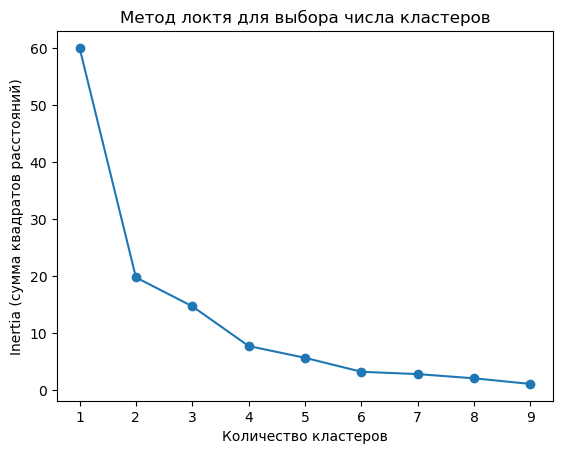

In [16]:
# Масштабирование данных (важно для KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(profit_profile)

# Определим оптимальное число кластеров через метод "локтя"
inertia = []
K = range(1, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

plt.plot(K, inertia, 'o-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia (сумма квадратов расстояний)')
plt.title('Метод локтя для выбора числа кластеров')
plt.show()

**Применение KMeans и визуализация**    
Разбиение на 5 кластеров является обоснованным, так как на графике «локтя» наблюдается выраженное замедление темпа снижения инерции (суммы квадратов расстояний) после пятого кластера, что указывает на точку излома. Добавление большего количества кластеров приводит к незначительному уменьшению инерции, что свидетельствует о снижении прироста качества кластеризации. Таким образом, выбор пяти кластеров обеспечивает баланс между интерпретируемостью модели и сохранением информативности группировки данных.

In [17]:
# Применим кластеризацию
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Замена названия для оптимизации отображения на графике
profit_profile.rename(
    index={'Индивидуальный предприниматель Кочанов Андрей Миха': 'ИП Кочанов'},
    inplace=True
)

# Добавим к исходным данным
profit_profile['cluster'] = clusters

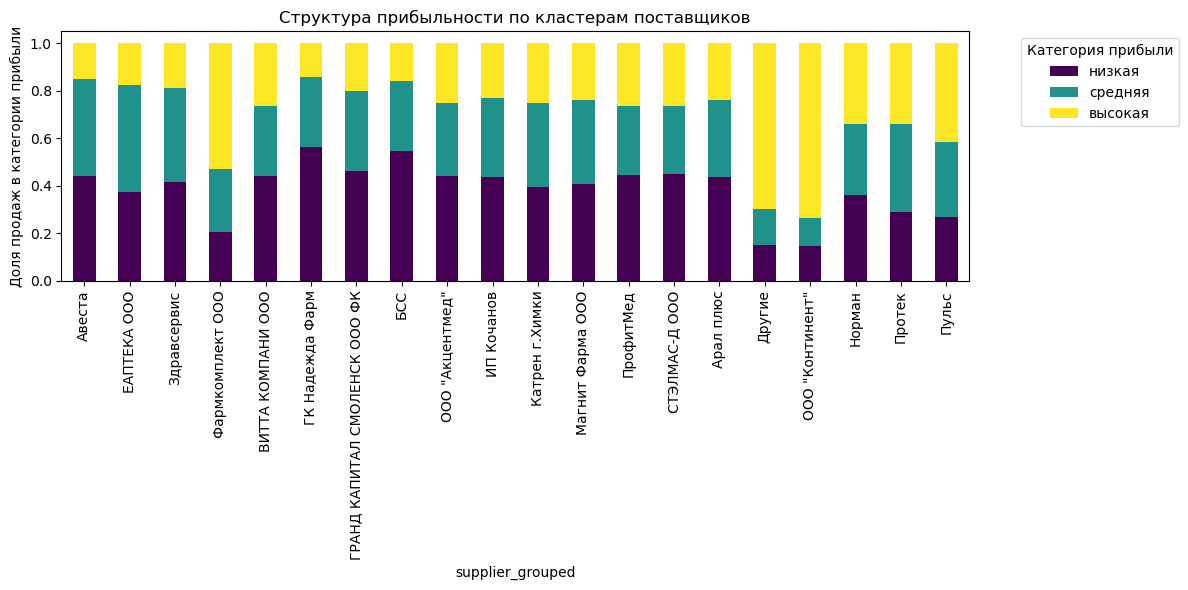

In [18]:
# Визуализируем стековую диаграмму
profit_profile_sorted = profit_profile.sort_values('cluster')

ax = profit_profile_sorted.drop('cluster', axis=1).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='viridis'
)

plt.title('Структура прибыльности по кластерам поставщиков')
plt.ylabel('Доля продаж в категории прибыли', fontsize=10)

# Легенда вне графика справа
plt.legend(title='Категория прибыли', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
profit_profile_sorted

profit_category_3,низкая,средняя,высокая,cluster
supplier_grouped,,,,
Авеста,0.442029,0.408213,0.149758,0
ЕАПТЕКА ООО,0.374317,0.448087,0.177596,0
Здравсервис,0.414184,0.395745,0.190071,0
Фармкомплект ООО,0.205021,0.266109,0.528870,1
ВИТТА КОМПАНИ ООО,0.440000,0.294286,0.265714,2
ГК Надежда Фарм,0.562500,0.294643,0.142857,2
ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,0.461791,0.339359,0.198850,2
БСС,0.547619,0.293651,0.158730,2
"ООО ""Акцентмед""",0.442815,0.304985,0.252199,2


In [20]:
# Средний профиль по кластерам
cluster_summary = profit_profile.groupby('cluster').mean()
display(cluster_summary)

profit_category_3,низкая,средняя,высокая
cluster,,,
0,0.410177,0.417348,0.172475
1,0.205021,0.266109,0.528870
2,0.456611,0.315550,0.227840
3,0.148126,0.134968,0.716906
4,0.305421,0.329348,0.365231


**Интерпретация сегментов (кластеров)**

Модель кластеризации на 5 групп демонстрирует, что поставщики не являются однородными — они работают по разным стратегиям, влияющим на ассортимент, прибыльность и ценовую политику. Каждая из выявленных групп (кластеров) представляет отдельный тип поставщика, с которым нужно выстраивать индивидуальную стратегию взаимодействия.

Кластер 0 — Стабильные средние:   
Сбалансированная структура между "низкой" и "средней" прибыльностью, с незначительной долей "высокой".  
*Возможная интерпретация:* Поставщики со стандартным ассортиментом, ориентированные на стабильные продажи в среднем ценовом сегменте. Вероятно, они обеспечивают надёжный, но не маржинально-выгодный товарный поток.   
*Характеристика:* Поставляют товары с умеренной прибыльностью, без резких перекосов.  
*Значение:* Это «база» — надёжные партнёры, которые обеспечивают стабильный оборот.  
*Управленческое действие:* Поддерживать долгосрочные отношения, контролировать условия, но без необходимости жёстких перего  
 
Кластер 1 — Премиальные:  
Преобладает "высокая" прибыльность (около 53%), при сравнительно низкой доле "низкой" и "средней".  
Возможная интерпретация: Поставщики с фокусом на высокомаржинальные товары. Возможно, это партнёры с уникальными или эксклюзивными предложениями, важные для повышения рентабельности бизнеса.  
*Характеристика:* Основной источник высокой маржи.  
*Значение:* Эти поставщики критически важны для общей прибыльности бизнеса.
*Управленческое действие:* Нужно уделять особое внимание — возможно, предлагать эксклюзивные условия, рассматривать совместные программы, приоритет в оплате или логистике.

Кластер 2 — Массовые:  
Доминирует "низкая" прибыльность (около 44–56%), далее следуют "средняя" и "высокая" с заметно меньшими долями.
*Возможная интерпретация:* Основные операционные партнёры с широким, но недорогим ассортиментом. Возможно, обеспечивают объём и доступность товара, жертвуя прибылью на единицу.  
*Характеристика:* Продают дешёвые товары с низкой наценкой, но, вероятно, в больших объёмах.  
*Значение:* Обеспечивают доступность и охват, особенно в чувствительных к цене сегментах.  
*Управленческое действие:* Ставка на объём, жёсткий контроль закупочных цен, возможно — тендерные подходы или консолидация поставок.  

Кластер 3 — Нишевые:  
Очень высокая доля "высокой" прибыльности (более 69%), низкие значения по остальным категориям.
*Возможная интерпретация:* Нишевые или премиальные поставщики, ориентированные исключительно на высокомаржинальные товары. Вероятно, это редкие, но ценные партнёры, обеспечивающие значительную прибыль при малом объёме.    
*Характеристика:* Высокая прибыльность при ограниченном ассортименте.  
*Значение:* Эти поставщики могут обеспечивать дифференциацию ассортимента, уникальность предложения.  
*Управленческое действие:* Выстраивать партнёрства, инвестировать в продвижение нишевых товаров, возможно — заключение эксклюзивных контрактов.

Кластер 4 — Гибкие универсалы:  
Относительно равномерное распределение между тремя категориями, с небольшим перевесом в сторону "высокой" прибыли.
*Возможная интерпретация:* Универсальные поставщики с диверсифицированным предложением. Могут работать в разных сегментах, адаптируясь под спрос, что делает их гибкими партнёрами для различных товарных стратегий.   
*Характеристика:* Продукты с разной прибыльностью, хорошо сбалансированное предложение.  
*Значение:* Универсальные партнёры, способные адаптироваться к изменяющимся потребностям.  
*Управленческое действие:* Использовать как резерв или поддержку в случае изменения стратегии — например, переключение на более маржинальные категории или наоборот, расширение ассортимента по низкой цене.  

**Результаты**  
- Chi²-тест (проверка независимости):  
    - Статистика χ² = 1215.28,  
    - Степени свободы (DoF) = 38  
    - p-value ≈ 2.6e-230  
    - Минимальное ожидаемое значение в ячейке: 10.997
Результаты свидетельствуют о сильном отклонении от независимости.  

- Перестановочный (Monte Carlo) χ²-тест:  
    - Эмпирическое p-value ≈ 0.00000 (на основе 5000 перестановок)  
Подтверждает устойчивость результата классического χ²-теста, устраняя возможные нарушения его предпосылок (например, несбалансированность).  

- Пост-хок анализ (все пары поставщиков):  
    - Проведено > 200 попарных сравнений с перестановочным тестом и FDR-коррекцией.
    - Более 100 пар поставщиков продемонстрировали статистически значимые различия (FDR < 0.05) в структуре прибыльности.


**Значение для бизнеса**  
- Категория прибыльности клиента значимо связана с поставщиком.  
Это означает, что разные поставщики обеспечивают разные профили прибыльности (например, один поставщик может приносить больше высокоприбыльных продаж, другой — низкоприбыльных).  
- Значимость остаётся высокой даже после жёсткой множественной коррекции (FDR), что подтверждает надежность и системность различий, а не случайные всплески.  
- Это даёт основание рассматривать поставщика как ключевой фактор, влияющий на экономическую эффективность закупочной политики.  


**Рекомендации**  
1.	Пересмотреть условия сотрудничества с поставщиками, чья структура прибыли системно неблагоприятна (доминирование низкой прибыльности), особенно если объёмы закупок значительные.  
2.	Фокусировать маркетинг и аналитику на тех поставщиках, кто обеспечивает высокую долю высокоприбыльных продаж.  
3.	Автоматизировать мониторинг структуры прибыли по поставщикам в регулярной BI-отчетности — это позволит оперативно выявлять изменения и оптимизировать ассортиментную матрицу.  
4.	Провести дополнительный анализ:  
    - Контролируя влияние категорий товаров, брендов, сезонности.  
    - Учитывая логистические и договорные параметры поставщиков.  